# **Lead Scoring Case Study**

In [1]:
# import libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

## *Step 1: Data cleaning and preparation*

- Handling categorical variables
    - Mapping categorical variables to integers
    - Dummy variable creation
- Handling outliers & missing values

### Data Importing

In [2]:
# import Leads data
leads = pd.read_csv('data/Leads.csv')
leads.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,...,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,...,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,...,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [3]:
leads.shape

(9240, 37)

In [4]:
# check columns type
leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

In [5]:
# Change name of some columns
leads.rename(columns={
    'How did you hear about X Education': 'source',
    'What is your current occupation': 'occupation',
    'What matters most to you in choosing a course': 'course_preference',
    'Total Time Spent on Website': 'total_time_on_website',
    'Receive More Updates About Our Courses': 'receive_updates',
    'Update me on Supply Chain Content': 'supply_chain_updates',
    'Get updates on DM Content': 'dm_content_updates',
    'I agree to pay the amount through cheque': 'cheque_payment_agreement',
    'A free copy of Mastering The Interview': 'free_copy_mastering_interview'
}, inplace=True)

### 1. Checking column with only one value (Unique value column)

In [6]:
uni_column = []
for i in leads.columns:
    if leads[i].unique().size ==1:
        uni_column.append(i)

In [7]:
# All columns with only one value.
uni_column

['Magazine',
 'receive_updates',
 'supply_chain_updates',
 'dm_content_updates',
 'cheque_payment_agreement']

- Take a look from above, there are some columns that contain only one value. (Single Unique Value)  
- Columns: **Magazine, receive_updates, supply_chain_updates, dm_content_updates, cheque_payment_agreement** 
 
=> Drop all these columns 

In [8]:
leads.drop(uni_column, axis=1, inplace= True)

In [9]:
leads.shape

(9240, 32)

### 1.1. Refine the dataset

In [10]:
# Check the values in the categorical variables
for i in leads.select_dtypes(include="object").columns:
    leads[i].value_counts(normalize=True)

Prospect ID
571b5c8e-a5b2-4d57-8574-f2ffb06fdeff    0.000108
7927b2df-8bba-4d29-b9a2-b6e0beafe620    0.000108
2a272436-5132-4136-86fa-dcc88c88f482    0.000108
8cc8c611-a219-4f35-ad23-fdfd2656bd8a    0.000108
0cc2df48-7cf4-4e39-9de9-19797f9b38cc    0.000108
                                          ...   
6d143c0e-abae-425f-a2c0-52c2946cbd45    0.000108
8247051c-f838-4a41-b39c-1f0b44c3d5e6    0.000108
b3455e2e-8236-478a-b1aa-666ad3381722    0.000108
da8c5ce5-52b5-4a4e-bf75-e533d2aca52c    0.000108
d2055a36-b268-43a0-beeb-9a715f6a660d    0.000108
Name: proportion, Length: 9240, dtype: float64

Lead Origin
Landing Page Submission    0.528788
API                        0.387446
Lead Add Form              0.077706
Lead Import                0.005952
Quick Add Form             0.000108
Name: proportion, dtype: float64

Lead Source
Google               0.311604
Direct Traffic       0.276293
Olark Chat           0.190678
Organic Search       0.125380
Reference            0.058018
Welingak Website     0.015428
Referral Sites       0.013581
Facebook             0.005976
bing                 0.000652
google               0.000543
Click2call           0.000435
Live Chat            0.000217
Social Media         0.000217
Press_Release        0.000217
Pay per Click Ads    0.000109
blog                 0.000109
WeLearn              0.000109
welearnblog_Home     0.000109
youtubechannel       0.000109
testone              0.000109
NC_EDM               0.000109
Name: proportion, dtype: float64

Do Not Email
No     0.920563
Yes    0.079437
Name: proportion, dtype: float64

Do Not Call
No     0.999784
Yes    0.000216
Name: proportion, dtype: float64

Last Activity
Email Opened                    0.376163
SMS Sent                        0.300427
Olark Chat Conversation         0.106490
Page Visited on Website         0.070045
Converted to Lead               0.046843
Email Bounced                   0.035679
Email Link Clicked              0.029222
Form Submitted on Website       0.012696
Unreachable                     0.010178
Unsubscribed                    0.006676
Had a Phone Conversation        0.003283
Approached upfront              0.000985
View in browser link Clicked    0.000657
Email Marked Spam               0.000219
Email Received                  0.000219
Resubscribed to emails          0.000109
Visited Booth in Tradeshow      0.000109
Name: proportion, dtype: float64

Country
India                   0.957663
United States           0.010178
United Arab Emirates    0.007818
Singapore               0.003540
Saudi Arabia            0.003098
United Kingdom          0.002213
Australia               0.001918
Qatar                   0.001475
Hong Kong               0.001033
Bahrain                 0.001033
Oman                    0.000885
France                  0.000885
unknown                 0.000738
Kuwait                  0.000590
South Africa            0.000590
Nigeria                 0.000590
Germany                 0.000590
Canada                  0.000590
Sweden                  0.000443
Italy                   0.000295
Belgium                 0.000295
Ghana                   0.000295
Philippines             0.000295
Netherlands             0.000295
China                   0.000295
Asia/Pacific Region     0.000295
Bangladesh              0.000295
Uganda                  0.000295
Russia                  0.000148
Sri Lanka               0.000148
Ta

Specialization
Select                               0.248911
Finance Management                   0.125096
Human Resource Management            0.108690
Marketing Management                 0.107408
Operations Management                0.064471
Business Administration              0.051653
IT Projects Management               0.046911
Supply Chain Management              0.044732
Banking, Investment And Insurance    0.043322
Media and Advertising                0.026019
Travel and Tourism                   0.026019
International Business               0.022815
Healthcare Management                0.020379
Hospitality Management               0.014612
E-COMMERCE                           0.014355
Retail Management                    0.012817
Rural and Agribusiness               0.009357
E-Business                           0.007306
Services Excellence                  0.005127
Name: proportion, dtype: float64

source
Select                   0.717048
Online Search            0.114887
Word Of Mouth            0.049481
Student of SomeSchool    0.044078
Other                    0.026447
Multiple Sources         0.021612
Advertisements           0.009953
Social Media             0.009527
Email                    0.003697
SMS                      0.003270
Name: proportion, dtype: float64

occupation
Unemployed              0.854962
Working Professional    0.107786
Student                 0.032061
Other                   0.002443
Housewife               0.001527
Businessman             0.001221
Name: proportion, dtype: float64

course_preference
Better Career Prospects      0.999541
Flexibility & Convenience    0.000306
Other                        0.000153
Name: proportion, dtype: float64

Search
No     0.998485
Yes    0.001515
Name: proportion, dtype: float64

Newspaper Article
No     0.999784
Yes    0.000216
Name: proportion, dtype: float64

X Education Forums
No     0.999892
Yes    0.000108
Name: proportion, dtype: float64

Newspaper
No     0.999892
Yes    0.000108
Name: proportion, dtype: float64

Digital Advertisement
No     0.999567
Yes    0.000433
Name: proportion, dtype: float64

Through Recommendations
No     0.999242
Yes    0.000758
Name: proportion, dtype: float64

Tags
Will revert after reading the email                  0.351962
Ringing                                              0.204349
Interested in other courses                          0.087141
Already a student                                    0.078988
Closed by Horizzon                                   0.060812
switched off                                         0.040768
Busy                                                 0.031595
Lost to EINS                                         0.029727
Not doing further education                          0.024631
Interested  in full time MBA                         0.019874
Graduation in progress                               0.018855
invalid number                                       0.014099
Diploma holder (Not Eligible)                        0.010702
wrong number given                                   0.007984
opp hangup                                           0.005606
number not provided                                  0.004586
in 

Lead Quality
Might be             0.348759
Not Sure             0.244131
High in Relevance    0.142410
Worst                0.134362
Low in Relevance     0.130338
Name: proportion, dtype: float64

Lead Profile
Select                         0.634819
Potential Lead                 0.246976
Other Leads                    0.074567
Student of SomeSchool          0.036901
Lateral Student                0.003675
Dual Specialization Student    0.003062
Name: proportion, dtype: float64

City
Mumbai                         0.412020
Select                         0.287596
Thane & Outskirts              0.096164
Other Cities                   0.087724
Other Cities of Maharashtra    0.058440
Other Metro Cities             0.048593
Tier II Cities                 0.009463
Name: proportion, dtype: float64

Asymmetrique Activity Index
02.Medium    0.764436
01.High      0.163481
03.Low       0.072083
Name: proportion, dtype: float64

Asymmetrique Profile Index
02.Medium    0.555157
01.High      0.438670
03.Low       0.006173
Name: proportion, dtype: float64

free_copy_mastering_interview
No     0.687446
Yes    0.312554
Name: proportion, dtype: float64

Last Notable Activity
Modified                        0.368723
Email Opened                    0.305952
SMS Sent                        0.235065
Page Visited on Website         0.034416
Olark Chat Conversation         0.019805
Email Link Clicked              0.018723
Email Bounced                   0.006494
Unsubscribed                    0.005087
Unreachable                     0.003463
Had a Phone Conversation        0.001515
Email Marked Spam               0.000216
Approached upfront              0.000108
Resubscribed to emails          0.000108
View in browser link Clicked    0.000108
Form Submitted on Website       0.000108
Email Received                  0.000108
Name: proportion, dtype: float64

"Lead Source" columns is quite messy and need to be cleaned.

In [11]:
# "Lead Source" columns are in both upper and lowercase, so we need to convert them to lowercase
leads['Lead Source'] = leads['Lead Source'].str.lower()

# there are multiple values that represent the same lead source
leads['Lead Source'] = leads['Lead Source'].replace(r'welearn.*', 'welearn', regex=True)
leads['Lead Source'] = leads['Lead Source'].replace(r'refer.*', 'referral', regex=True)

Many of the categorical variables have a level called 'Select' which needs to be handled because it is as good as a null value

In [12]:
# treat "Select" as NULL
leads.replace('Select', np.nan, inplace=True)

The "Lead Profile" column is labeled with either "Potential Lead" or meaningless labels such as "Other". We can take advantage of this "Potential Lead" label!

In [13]:
leads['Is_Potential_Lead'] = np.where(leads['Lead Profile'] == "Potential Lead", 1, 0)
leads['Is_Potential_Lead'].value_counts(normalize=True)

Is_Potential_Lead
0    0.825433
1    0.174567
Name: proportion, dtype: float64

In [14]:
# column "Country" is highly skewed toward "India", and columns "Prospect ID" & "Lead Number" is not needed
leads.drop(columns=["Country", "Prospect ID", "Lead Number"], inplace=True)

### 2. Handling with missing values

In [15]:
# Checking the missing values
missing_rate = leads.isnull().sum()*100/leads.shape[0]

# Extract all columns containing missing values
missing_rate[missing_rate!=0].sort_values(ascending=False)

source                         78.463203
Lead Profile                   74.188312
Lead Quality                   51.590909
Asymmetrique Profile Index     45.649351
Asymmetrique Activity Index    45.649351
Asymmetrique Activity Score    45.649351
Asymmetrique Profile Score     45.649351
City                           39.707792
Specialization                 36.580087
Tags                           36.287879
course_preference              29.318182
occupation                     29.112554
TotalVisits                     1.482684
Page Views Per Visit            1.482684
Last Activity                   1.114719
Lead Source                     0.389610
dtype: float64

#### Check high missing counts columns

In [16]:
# The 'source' column has high nulls count, so let drop it
leads.drop(columns= 'source', axis=1, inplace=True)

In [17]:
# since we already create a derived column from "Lead Profile", we can safely drop it
leads.drop(columns= 'Lead Profile', axis=1, inplace=True)

#### Check "Lead quality" column with ~50% missing values

In [18]:
leads["Lead Quality"].value_counts(normalize=True)

Lead Quality
Might be             0.348759
Not Sure             0.244131
High in Relevance    0.142410
Worst                0.134362
Low in Relevance     0.130338
Name: proportion, dtype: float64

- Data in this column has been not defined clearly. For example, it should be classified as **best**, **normal**, **worst** or **high**, **average**, **low**, but as this case, the data seems messy!  
=> This column will drop because of missing values and low quality

In [19]:
leads.drop(["Lead Quality"], axis=1, inplace = True)

#### Index and score columns with almost 50% missing value

In [20]:
asym_columns = ["Asymmetrique Profile Score", "Asymmetrique Activity Score", "Asymmetrique Profile Index", "Asymmetrique Activity Index"]

for i in asym_columns:
    leads[i].value_counts(normalize=True)

Asymmetrique Profile Score
15.0    0.350259
18.0    0.213262
16.0    0.119275
17.0    0.115293
20.0    0.061330
19.0    0.048785
14.0    0.045002
13.0    0.040621
12.0    0.004381
11.0    0.001792
Name: proportion, dtype: float64

Asymmetrique Activity Score
14.0    0.352648
15.0    0.257467
13.0    0.154321
16.0    0.092991
17.0    0.069494
12.0    0.039028
11.0    0.018917
10.0    0.011350
9.0     0.001792
18.0    0.000996
8.0     0.000796
7.0     0.000199
Name: proportion, dtype: float64

Asymmetrique Profile Index
02.Medium    0.555157
01.High      0.438670
03.Low       0.006173
Name: proportion, dtype: float64

Asymmetrique Activity Index
02.Medium    0.764436
01.High      0.163481
03.Low       0.072083
Name: proportion, dtype: float64

- In "Asymmetrique Profile Score" and "Asymmetrique Activity Score" columns, the difference between all values is not prominent.  
=> Imputing missing values with the median values.

In [21]:
leads["Asymmetrique Activity Score"].fillna(leads["Asymmetrique Activity Score"].median(), inplace = True)
leads["Asymmetrique Profile Score"].fillna(leads["Asymmetrique Profile Score"].median(), inplace = True)

- "Asymmetrique Profile Index" and "Asymmetrique Activity Index" columns are categorical and the proportions of values that occupy the highest part are over 50%.  
=> Replace missing values with the mode of the column.

In [22]:
leads["Asymmetrique Profile Index"].fillna(leads["Asymmetrique Profile Index"].mode()[0], inplace=True)
leads["Asymmetrique Activity Index"].fillna(leads["Asymmetrique Activity Index"].mode()[0], inplace=True)

#### All columns with moderate missing rates (15%-35%)

In [23]:
moderate_missing = ["City", "Specialization", "Tags", "course_preference", "occupation"]

In [24]:
for i in moderate_missing:
    leads[i].value_counts(normalize=True)

City
Mumbai                         0.578352
Thane & Outskirts              0.134985
Other Cities                   0.123138
Other Cities of Maharashtra    0.082032
Other Metro Cities             0.068210
Tier II Cities                 0.013283
Name: proportion, dtype: float64

Specialization
Finance Management                   0.166553
Human Resource Management            0.144710
Marketing Management                 0.143003
Operations Management                0.085836
Business Administration              0.068771
IT Projects Management               0.062457
Supply Chain Management              0.059556
Banking, Investment And Insurance    0.057679
Media and Advertising                0.034642
Travel and Tourism                   0.034642
International Business               0.030375
Healthcare Management                0.027133
Hospitality Management               0.019454
E-COMMERCE                           0.019113
Retail Management                    0.017065
Rural and Agribusiness               0.012457
E-Business                           0.009727
Services Excellence                  0.006826
Name: proportion, dtype: float64

Tags
Will revert after reading the email                  0.351962
Ringing                                              0.204349
Interested in other courses                          0.087141
Already a student                                    0.078988
Closed by Horizzon                                   0.060812
switched off                                         0.040768
Busy                                                 0.031595
Lost to EINS                                         0.029727
Not doing further education                          0.024631
Interested  in full time MBA                         0.019874
Graduation in progress                               0.018855
invalid number                                       0.014099
Diploma holder (Not Eligible)                        0.010702
wrong number given                                   0.007984
opp hangup                                           0.005606
number not provided                                  0.004586
in 

course_preference
Better Career Prospects      0.999541
Flexibility & Convenience    0.000306
Other                        0.000153
Name: proportion, dtype: float64

occupation
Unemployed              0.854962
Working Professional    0.107786
Student                 0.032061
Other                   0.002443
Housewife               0.001527
Businessman             0.001221
Name: proportion, dtype: float64

The ammount of null values (original known as "Select") are quite high for us to remove (since it will cost alot of data), but we cannot impute them with the median. So let convert them to "unknow" for now, and keep in mind to remove them in our future models.

In [25]:
# replace missing values with "unknown"
leads[moderate_missing] = leads[moderate_missing].fillna('unknown')

In [26]:
# too much "Other" labels in City variable
leads["City"].replace({
    "Other Cities of Maharashtra": "Other Cities", 
    "Other Metro Cities": "Other Cities"}, 
    inplace = True)

#### Columns with Low Missing Rates (<2%)

In [27]:
# Removing rows with missing values
leads.dropna(subset=["TotalVisits", "Page Views Per Visit", "Last Activity", "Lead Source"], inplace=True)

### 3. Handling redundancy in categorical columns

In [28]:
# check the values of categorical variables
for i in leads.select_dtypes(include="object").columns:
    leads[i].value_counts(normalize=True)

Lead Origin
Landing Page Submission    0.538351
API                        0.394313
Lead Add Form              0.064029
Lead Import                0.003306
Name: proportion, dtype: float64

Lead Source
google               0.316619
direct traffic       0.280251
olark chat           0.193189
organic search       0.127177
referral             0.062596
welingak website     0.014216
facebook             0.003416
bing                 0.000661
click2call           0.000441
social media         0.000220
press_release        0.000220
live chat            0.000220
welearn              0.000220
blog                 0.000110
pay per click ads    0.000110
youtubechannel       0.000110
testone              0.000110
nc_edm               0.000110
Name: proportion, dtype: float64

Do Not Email
No     0.921093
Yes    0.078907
Name: proportion, dtype: float64

Do Not Call
No     0.99978
Yes    0.00022
Name: proportion, dtype: float64

Last Activity
Email Opened                    0.378223
SMS Sent                        0.299317
Olark Chat Conversation         0.107119
Page Visited on Website         0.070531
Converted to Lead               0.047168
Email Bounced                   0.034384
Email Link Clicked              0.029425
Form Submitted on Website       0.012784
Unreachable                     0.009918
Unsubscribed                    0.006502
Had a Phone Conversation        0.002755
View in browser link Clicked    0.000661
Approached upfront              0.000551
Email Marked Spam               0.000220
Email Received                  0.000220
Visited Booth in Tradeshow      0.000110
Resubscribed to emails          0.000110
Name: proportion, dtype: float64

Specialization
unknown                              0.361693
Finance Management                   0.105687
Human Resource Management            0.092242
Marketing Management                 0.090699
Operations Management                0.054992
Business Administration              0.043972
IT Projects Management               0.040335
Supply Chain Management              0.038131
Banking, Investment And Insurance    0.036919
Media and Advertising                0.022261
Travel and Tourism                   0.022261
International Business               0.019396
Healthcare Management                0.017192
Hospitality Management               0.012233
E-COMMERCE                           0.012233
Retail Management                    0.011020
Rural and Agribusiness               0.008045
E-Business                           0.006282
Services Excellence                  0.004408
Name: proportion, dtype: float64

occupation
Unemployed              0.603482
unknown                 0.295680
Working Professional    0.074609
Student                 0.022702
Other                   0.001653
Housewife               0.000992
Businessman             0.000882
Name: proportion, dtype: float64

course_preference
Better Career Prospects      0.702006
unknown                      0.297774
Flexibility & Convenience    0.000110
Other                        0.000110
Name: proportion, dtype: float64

Search
No     0.998457
Yes    0.001543
Name: proportion, dtype: float64

Newspaper Article
No     0.99978
Yes    0.00022
Name: proportion, dtype: float64

X Education Forums
No     0.99989
Yes    0.00011
Name: proportion, dtype: float64

Newspaper
No     0.99989
Yes    0.00011
Name: proportion, dtype: float64

Digital Advertisement
No     0.999559
Yes    0.000441
Name: proportion, dtype: float64

Through Recommendations
No     0.999229
Yes    0.000771
Name: proportion, dtype: float64

Tags
unknown                                              0.366652
Will revert after reading the email                  0.222173
Ringing                                              0.130813
Interested in other courses                          0.056094
Already a student                                    0.051245
Closed by Horizzon                                   0.033172
switched off                                         0.026449
Busy                                                 0.020388
Lost to EINS                                         0.018955
Not doing further education                          0.015980
Interested  in full time MBA                         0.012784
Graduation in progress                               0.012233
invalid number                                       0.009147
Diploma holder (Not Eligible)                        0.006943
wrong number given                                   0.005180
opp hangup                                           0.003637
num

City
unknown              0.393983
Mumbai               0.350121
Other Cities         0.165638
Thane & Outskirts    0.082103
Tier II Cities       0.008155
Name: proportion, dtype: float64

Asymmetrique Activity Index
02.Medium    0.869738
01.High      0.090368
03.Low       0.039894
Name: proportion, dtype: float64

Asymmetrique Profile Index
02.Medium    0.759202
01.High      0.237382
03.Low       0.003416
Name: proportion, dtype: float64

free_copy_mastering_interview
No     0.681728
Yes    0.318272
Name: proportion, dtype: float64

Last Notable Activity
Modified                        0.360040
Email Opened                    0.311109
SMS Sent                        0.237161
Page Visited on Website         0.035045
Olark Chat Conversation         0.020168
Email Link Clicked              0.019065
Email Bounced                   0.006612
Unsubscribed                    0.004959
Unreachable                     0.003527
Had a Phone Conversation        0.001543
Email Marked Spam               0.000220
Approached upfront              0.000110
Resubscribed to emails          0.000110
View in browser link Clicked    0.000110
Form Submitted on Website       0.000110
Email Received                  0.000110
Name: proportion, dtype: float64

- There some categorical columns with reduntdant values: **"Lead Source", "Last Activity", "Specialization", "Tags", "Last Notable Activity"**

In [29]:
def handle_redundancies(column):
    proportions = leads[column].value_counts(normalize=True)

    # Set a threshold for significant categories
    threshold = 0.05 # under 5% will be count as "Other"

    # Create a list of categories to keep (above the threshold)
    significant_categories = proportions[proportions > threshold].index.tolist()

    # Create a mapping where significant categories map to themselves and others map to 'Other'
    mapping = {category: (category if category in significant_categories else 'Other') for category in leads[column].unique()}

    # Apply the mapping to the DataFrame
    leads[column].replace(mapping, inplace = True)

In [30]:
reduntant_col = ["Lead Source", "Last Activity", "Specialization", "Tags", "Last Notable Activity"]

In [31]:
for i in reduntant_col:
    handle_redundancies(i)

### 4. Converting some binary variables (Yes/No) to 0/1

In [32]:
# List of variables to map
bi_cols = []
for i in leads.columns:
    if leads[i].unique().size == 2:
        bi_cols.append(i)
# "Converted" column already contains binary with 1,0
bi_cols.remove('Converted')
bi_cols.remove('Is_Potential_Lead')
bi_cols

['Do Not Email',
 'Do Not Call',
 'Search',
 'Newspaper Article',
 'X Education Forums',
 'Newspaper',
 'Digital Advertisement',
 'Through Recommendations',
 'free_copy_mastering_interview']

In [33]:
# Defining the map function
def binary_map(x):
    return x.map({'Yes': 1, "No": 0})

# Applying the function to the binary columns
leads[bi_cols] = leads[bi_cols].apply(binary_map)

In [34]:
# Two columns "Asymmetrique Activity Index", "Asymmetrique Profile Index" contains three categories, so lets convert them to numbers
index_mapping = {
    '01.High': 1,
    '02.Medium': 2,
    '03.Low': 3
}

leads['Asymmetrique Activity Index'] = leads['Asymmetrique Activity Index'].map(index_mapping)
leads['Asymmetrique Profile Index'] = leads['Asymmetrique Profile Index'].map(index_mapping)

In [35]:
leads['Asymmetrique Activity Index'].value_counts()
leads['Asymmetrique Profile Index'].value_counts()

Asymmetrique Activity Index
2    7892
1     820
3     362
Name: count, dtype: int64

Asymmetrique Profile Index
2    6889
1    2154
3      31
Name: count, dtype: int64

## *Step 2: EDA*

In [36]:
# set theme
sns.set_theme(style="whitegrid")

### 5. Check for outliers

In [37]:
# numerical columns
num_cols = ["TotalVisits", "total_time_on_website", "Page Views Per Visit"]

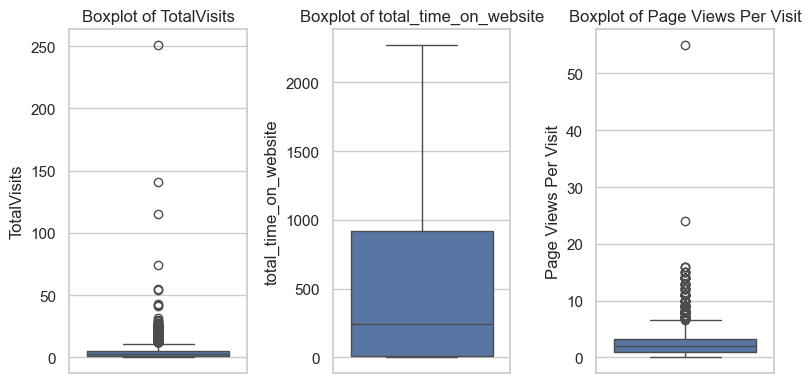

In [38]:
# plot the outliers using boxplot
plt.figure(figsize= (8, 4))
for i, col in enumerate(num_cols, 1):
    plt.subplot(1, 3, i)  # Adjust subplot based on the number of columns
    sns.boxplot(y=leads[col])
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
plt.show();

- There is outliers in "TotalVisits" & "Page Views Per Visit", which may have negative impacts on model's performance.

In [39]:
# check outliers of "TotalVisits" column
leads[leads['TotalVisits'] > 40].head()

,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,total_time_on_website,Page Views Per Visit,Last Activity,Specialization,...,Through Recommendations,Tags,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,free_copy_mastering_interview,Last Notable Activity,Is_Potential_Lead
1160,Landing Page Submission,direct traffic,0,0,0,43.0,57,3.91,Email Opened,Marketing Management,...,0,Other,Thane & Outskirts,3,1,11.0,17.0,0,Email Opened,0
2190,Landing Page Submission,direct traffic,1,0,0,55.0,297,55.00,Page Visited on Website,Other,...,0,unknown,Other Cities,1,2,17.0,13.0,1,Modified,0
2322,Landing Page Submission,direct traffic,1,0,0,141.0,755,6.71,Page Visited on Website,Human Resource Management,...,0,unknown,Mumbai,2,1,15.0,18.0,1,Other,0
5283,Landing Page Submission,direct traffic,1,0,0,74.0,1209,12.33,Page Visited on Website,unknown,...,0,Other,Thane & Outskirts,2,2,14.0,16.0,0,Other,0
5530,Landing Page Submission,direct traffic,1,0,0,41.0,311,1.14,Page Visited on Website,Other,...,0,unknown,Other Cities,2,2,14.0,16.0,0,Other,0


In [40]:
# check outliers of "TotalVisits" column
leads[leads['Page Views Per Visit'] > 10].head()

,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,total_time_on_website,Page Views Per Visit,Last Activity,Specialization,...,Through Recommendations,Tags,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,free_copy_mastering_interview,Last Notable Activity,Is_Potential_Lead
12,API,organic search,0,0,1,11.0,1538,11.0,Email Opened,Marketing Management,...,0,Will revert after reading the email,unknown,1,2,16.0,16.0,0,Modified,1
56,Landing Page Submission,referral,0,0,1,13.0,436,13.0,Other,Other,...,0,Other,Other Cities,2,2,15.0,13.0,0,Modified,1
125,API,referral,0,0,0,16.0,53,16.0,Olark Chat Conversation,unknown,...,0,unknown,unknown,2,2,15.0,13.0,0,Modified,0
168,Landing Page Submission,referral,0,0,0,12.0,493,12.0,Other,Marketing Management,...,0,unknown,Thane & Outskirts,1,2,16.0,16.0,1,Other,0
246,API,referral,0,0,0,14.0,354,14.0,Other,unknown,...,0,Ringing,unknown,2,2,14.0,13.0,0,Modified,0


- The outliers is reflecting real users's behaviour, so we shouldn't drop them!

### 6. Visualization

#### 6.1. Univariate analysis

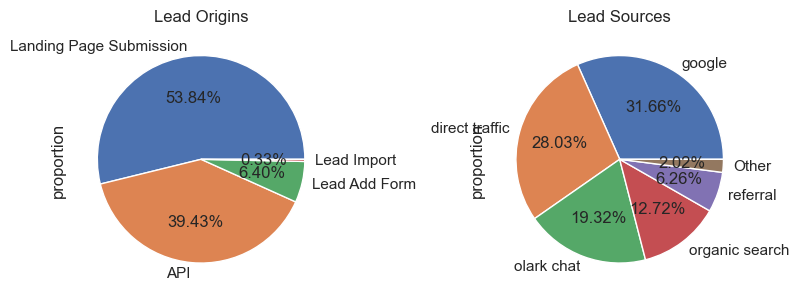

In [41]:
# check the proportions of values in "Lead Origin" & "Lead Source"
plt.figure(figsize= (8, 4))
plt.subplot(1, 2, 1)
leads["Lead Origin"].value_counts(normalize=True).plot.pie(autopct='%1.2f%%')
plt.title("Lead Origins")
plt.subplot(1, 2, 2)
leads["Lead Source"].value_counts(normalize=True).plot.pie(autopct='%1.2f%%')
plt.title("Lead Sources")
plt.tight_layout()
plt.show();

- The origin of leads mainly is from "Landing Page Submission" and "API"
- The source of leads mainly is from "google" and "direct traffic"

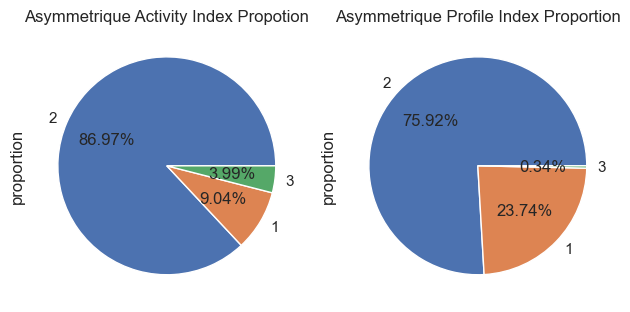

In [42]:
plt.subplot(1,2,1)
leads["Asymmetrique Activity Index"].value_counts(normalize=True).plot.pie(autopct='%1.2f%%')
plt.title("Asymmetrique Activity Index Propotion")
plt.subplot(1,2,2)
leads["Asymmetrique Profile Index"].value_counts(normalize=True).plot.pie(autopct='%1.2f%%')
plt.title("Asymmetrique Profile Index Proportion")
plt.tight_layout()
plt.show();

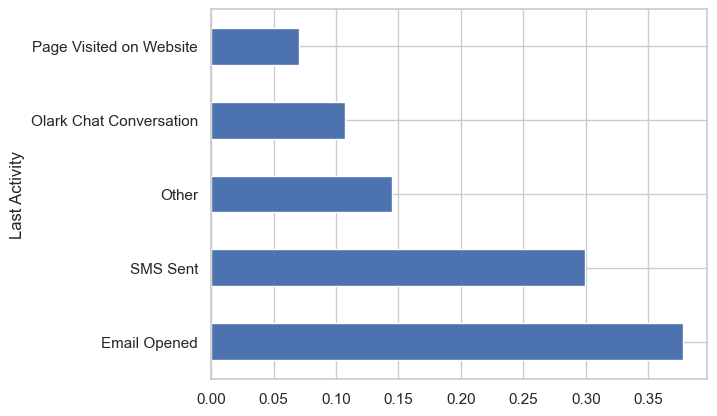

In [43]:
leads["Last Activity"].value_counts(normalize=True).plot.barh()
plt.show();

- Before the leads get converted, users were open their Email or sent SMS.

In [44]:
# List of variables to map
bi_cols = []
for i in leads.columns:
    if leads[i].unique().size == 2:
        bi_cols.append(i)

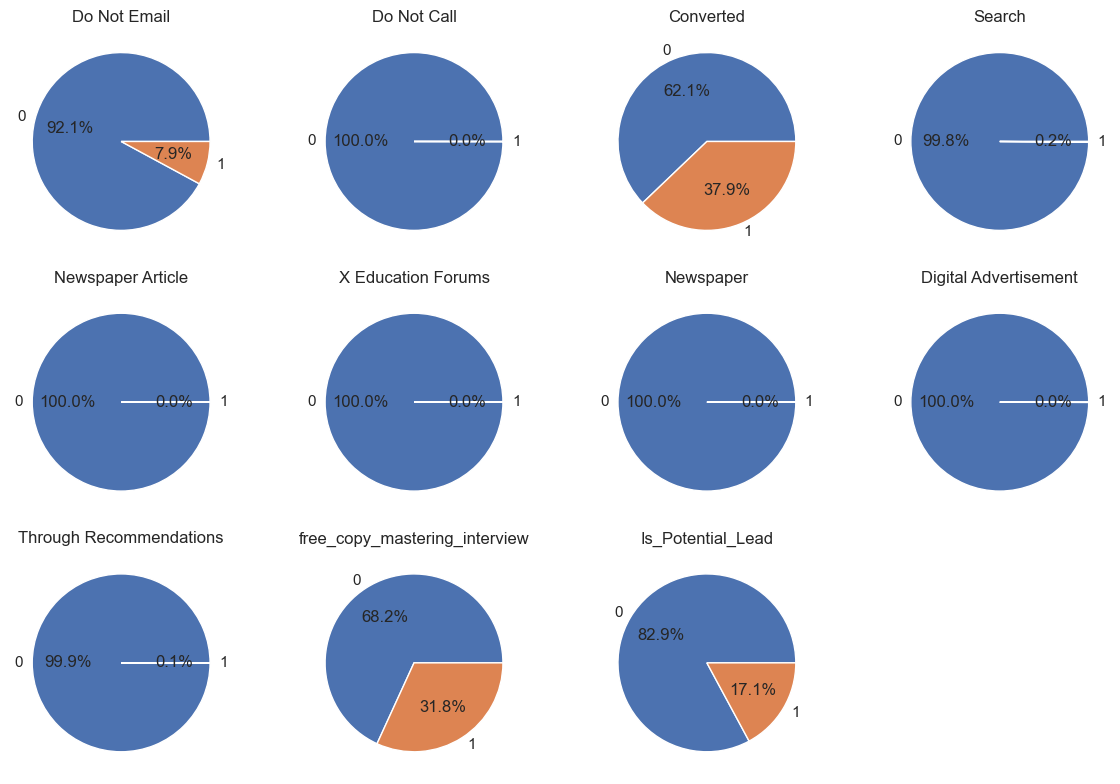

In [45]:
plt.figure(figsize=(12, 8))
for i in range(len(bi_cols)):
    plt.subplot(3,4,i+1)
    counts = leads[bi_cols[i]].value_counts(normalize=True)
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%')
    plt.title(bi_cols[i])
plt.tight_layout()
plt.show();

- Most of the customers are okay with receiving emails and calls about the course with over 90% say "No" with "Do not email" or "Do not call" even nearly 100%.
- However, almost advertisement platforms or measurements are not realy effective, because almost 100% customers said "No" about seeing ad before. 
Only in "free_copy_mastering_interview" field, there is 31,8% customers having desire to receive a free copy of 'Mastering the Interview'.
- Only 1/6 Leads are marked as Potential

#### 5.2. Bivariate analysis

In [46]:
leads.columns

Index(['Lead Origin', 'Lead Source', 'Do Not Email', 'Do Not Call',
       'Converted', 'TotalVisits', 'total_time_on_website',
       'Page Views Per Visit', 'Last Activity', 'Specialization', 'occupation',
       'course_preference', 'Search', 'Newspaper Article',
       'X Education Forums', 'Newspaper', 'Digital Advertisement',
       'Through Recommendations', 'Tags', 'City',
       'Asymmetrique Activity Index', 'Asymmetrique Profile Index',
       'Asymmetrique Activity Score', 'Asymmetrique Profile Score',
       'free_copy_mastering_interview', 'Last Notable Activity',
       'Is_Potential_Lead'],
      dtype='object')

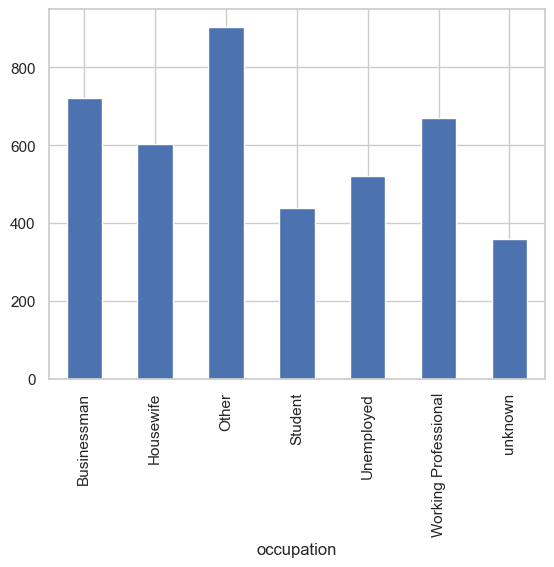

In [47]:
leads.groupby('occupation')["total_time_on_website"].mean().plot.bar()
plt.show();

- People who spent the most time on website are Businessman or working Professional. 

=> These groups of people are potential for this course.

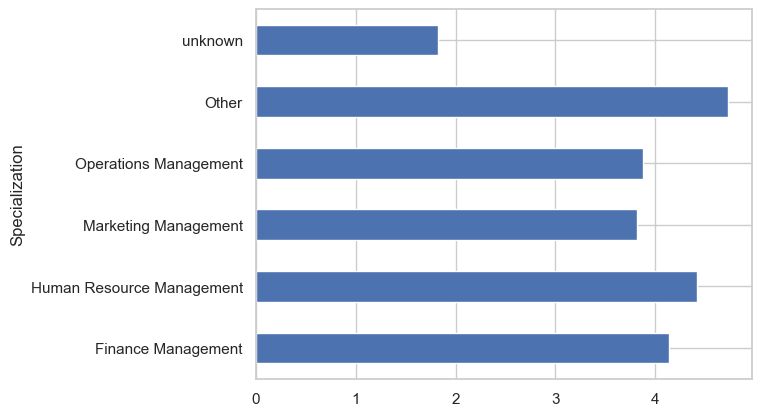

In [48]:
leads.groupby('Specialization')["TotalVisits"].mean().plot.barh()
plt.show();

- On average the users visits the website 4 times.

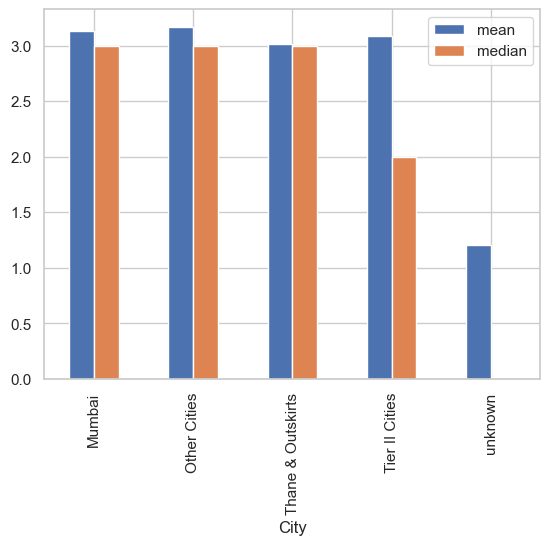

In [49]:
leads.groupby(['City'])['Page Views Per Visit'].aggregate(['mean','median']).plot.bar()
plt.show();

The chart shows the relationship between mean and median values across different city categories:

- Mumbai, Thane & Outskirts, and other cities have equal mean and median values, indicating symmetric data distributions.
- Tier II Cities has a higher mean than median, suggesting a right-skewed distribution.

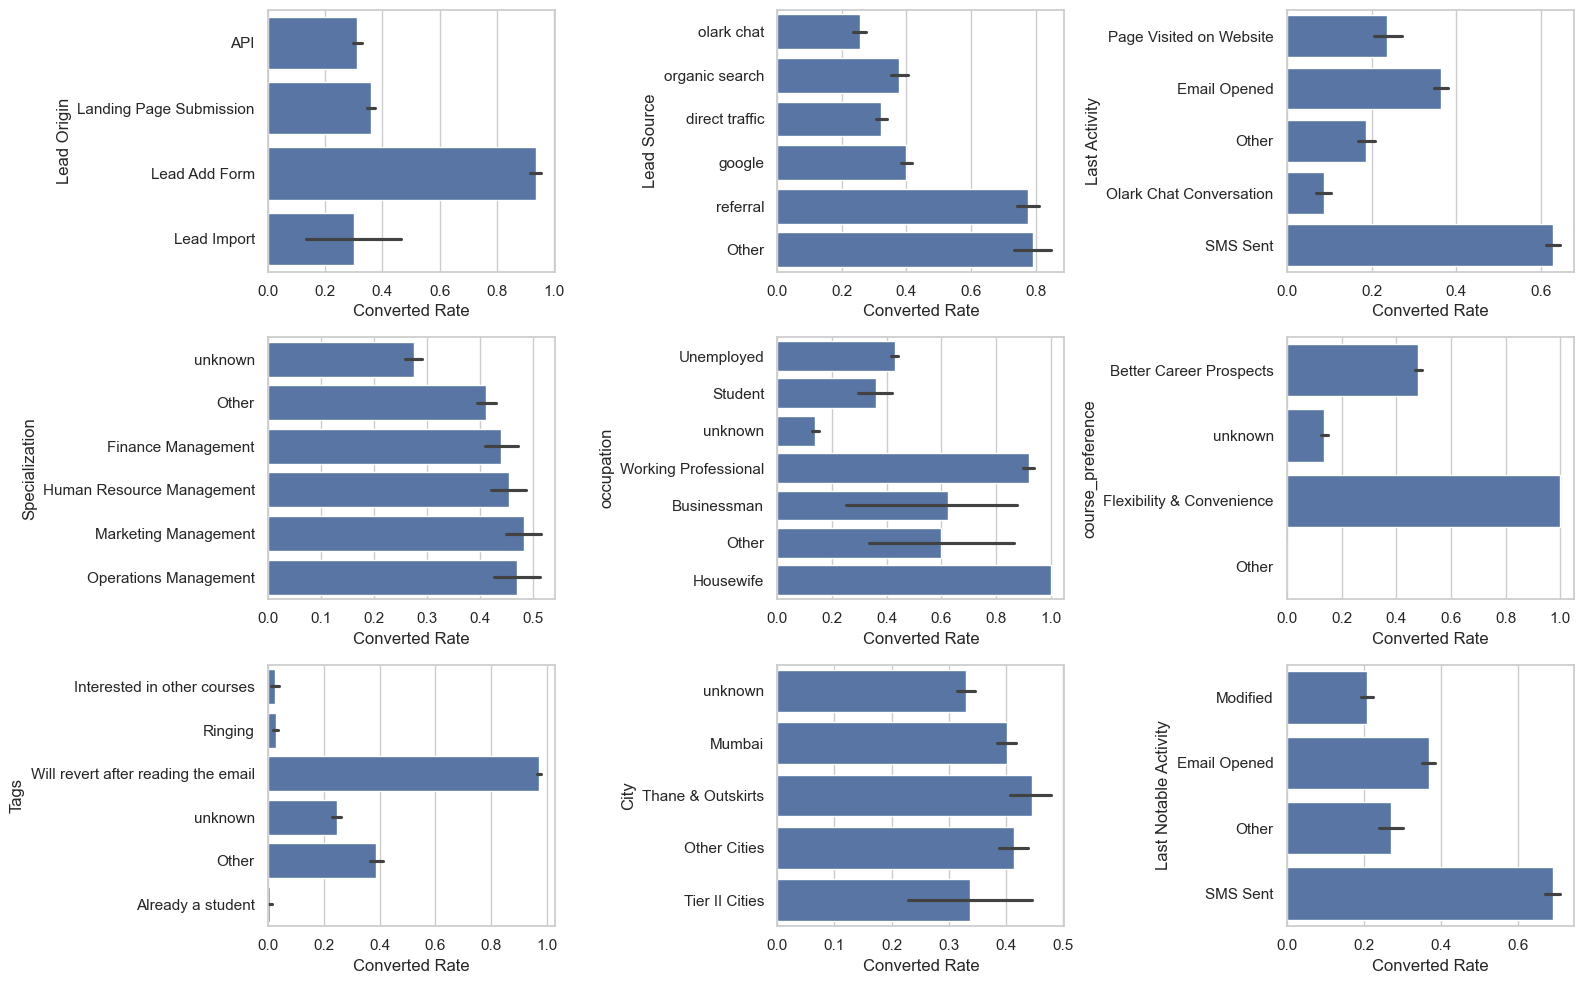

In [50]:
# Lets check how categorical variables perform on the Convertion (target values)
cate_cols = leads.select_dtypes(include= 'object').columns.tolist()
plt.figure(figsize=(16,10))
for i in range(len(cate_cols)):
    plt.subplot(3, 3, i+1)
    sns.barplot(data= leads, y= cate_cols[i], x= 'Converted')
    plt.xlabel('Converted Rate')
    plt.ylabel(cate_cols[i])
plt.tight_layout()
plt.show();

- Some strong indicators of a promissing lead:
    + Lead Origin: Lead Ad Form. This form initiate good leads
    + Lead Source: referral. Referral Source brings quality leads
    + Last Activity: SMS Sent. This will be a good signal
    + Occupation: Housewife, Professional
    + Course Prefers: Flexibility & Convenience. Seems like the company is delivering this aspect.
    + Tags: Will revert after reading the email. They definitely will!

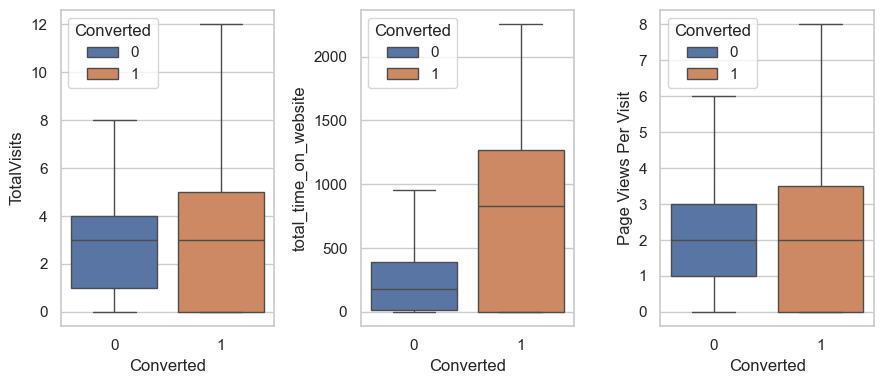

In [51]:
# next, how continuous variables affect Convertion Rate
plt.figure(figsize=(9,4))
for i in range(len(num_cols)):
    plt.subplot(1, 3, i+1)
    sns.boxplot(data= leads, y= num_cols[i], x= 'Converted', hue= 'Converted', showfliers=False) # ignore putliers
    plt.ylabel(num_cols[i])
plt.tight_layout()
plt.show();

- Converted Leads have doubled total time on website compare to non-converted leads

#### 5.3. Multivariate analysis

In [52]:
leads.dtypes

Lead Origin                       object
Lead Source                       object
Do Not Email                       int64
Do Not Call                        int64
Converted                          int64
TotalVisits                      float64
total_time_on_website              int64
Page Views Per Visit             float64
Last Activity                     object
Specialization                    object
occupation                        object
course_preference                 object
Search                             int64
Newspaper Article                  int64
X Education Forums                 int64
Newspaper                          int64
Digital Advertisement              int64
Through Recommendations            int64
Tags                              object
City                              object
Asymmetrique Activity Index        int64
Asymmetrique Profile Index         int64
Asymmetrique Activity Score      float64
Asymmetrique Profile Score       float64
free_copy_master

In [53]:
num_col = []
for i in leads.columns:
    if (leads[i].unique().dtype=="float64" or leads[i].unique().dtype=="int64") and leads[i].unique().size>2:
        num_col.append(i)

In [54]:
num_col.append('Converted')

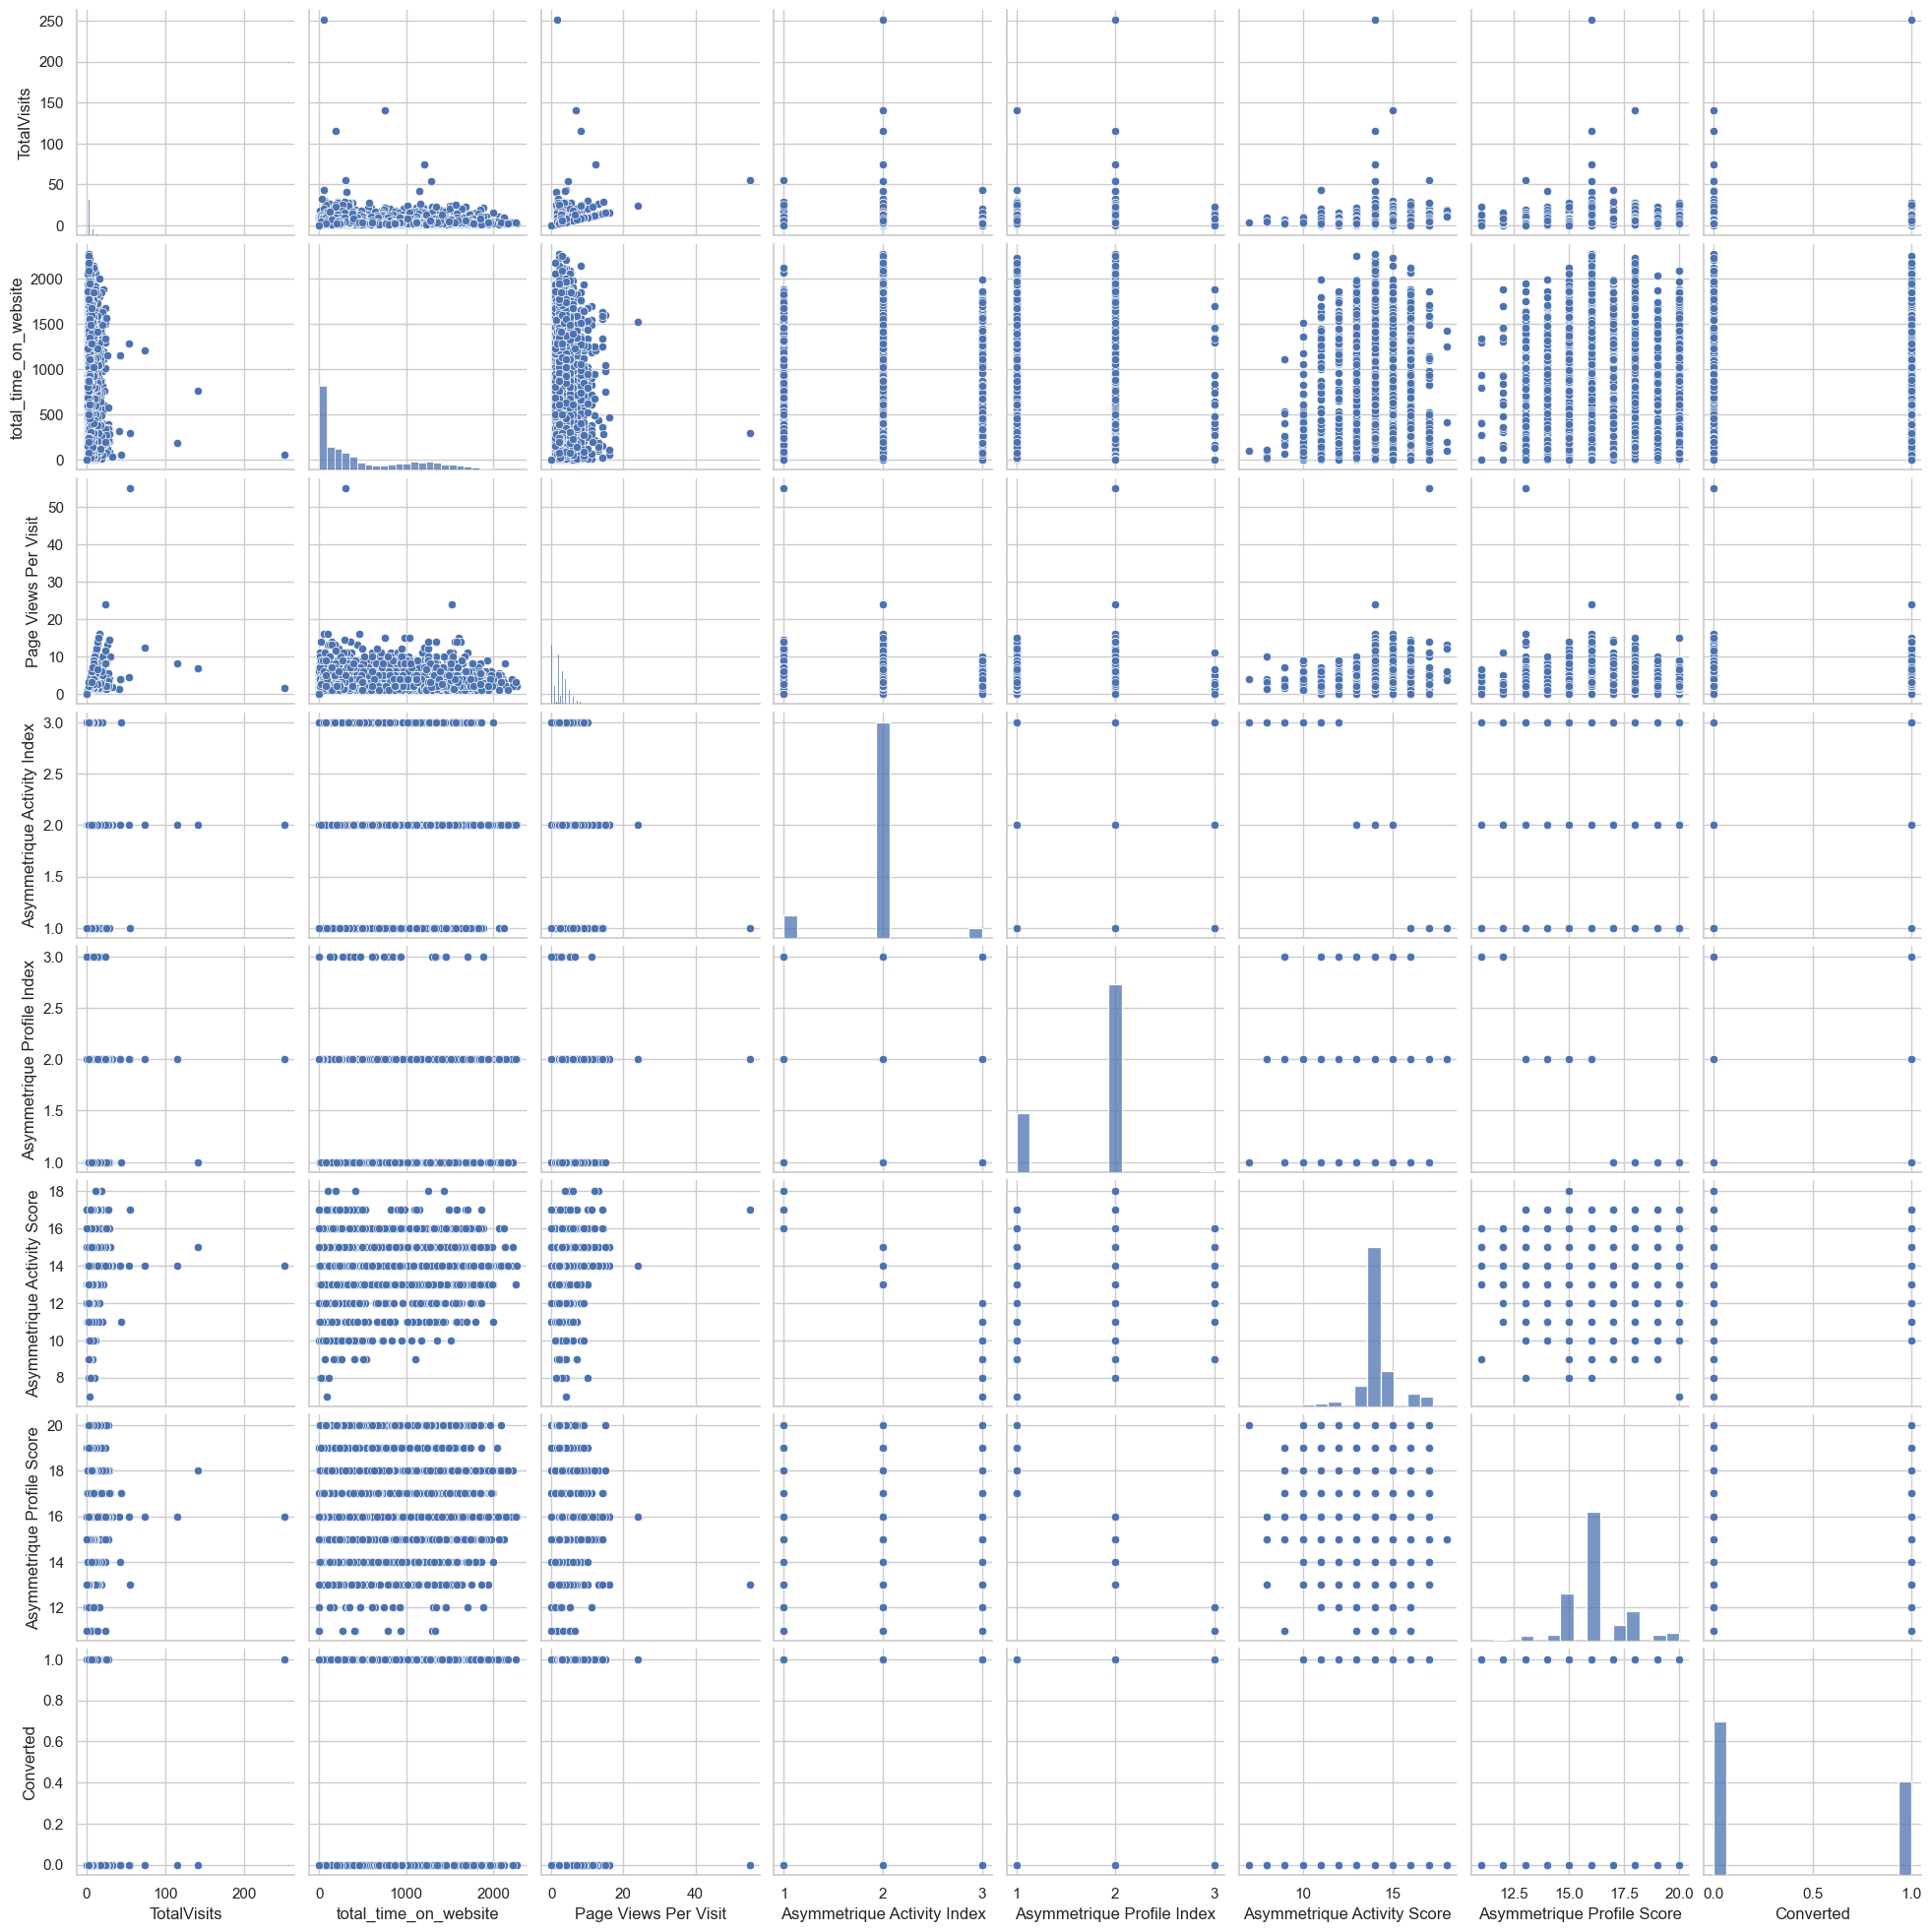

In [55]:
sns.pairplot(leads[num_col])
plt.show();

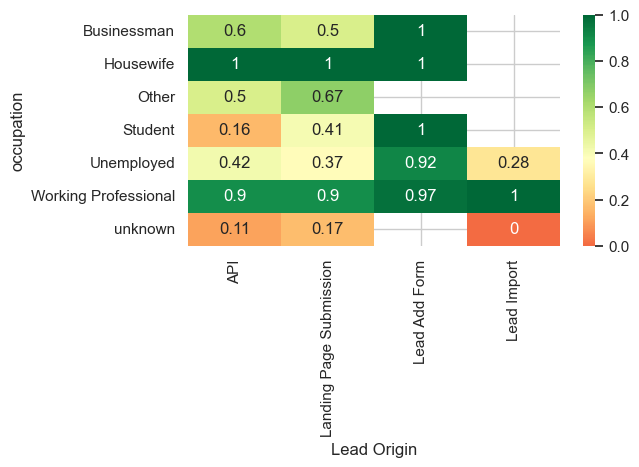

In [79]:
# segmenting Lead Origin based on occupation
plt.figure(figsize= (6, 3))
sns.heatmap(
    data= leads.pivot_table(index= 'occupation', columns= 'Lead Origin', values= 'Converted').round(2),
    cmap= 'RdYlGn', annot= True, center= leads['Converted'].mean())
plt.show();

- We can pretty much seal the deal with those who are Businessman, Working Professional, or came from Lead Add Form

### 6. Dummy variables

In [83]:
# declare variables that require dummy creation
dummy_cols = cate_cols
dummy_cols.extend(["Asymmetrique Activity Index", "Asymmetrique Profile Index"])
dummy_cols

['Lead Origin',
 'Lead Source',
 'Last Activity',
 'Specialization',
 'occupation',
 'course_preference',
 'Tags',
 'City',
 'Last Notable Activity',
 'Asymmetrique Activity Index',
 'Asymmetrique Profile Index']

- When creating dummy variables, the `drop_first=True` parameter is often used to avoid the **dummy variable trap** and to simplify the resulting dataset.

In [84]:
# Get the dummy variables for categorical variables.
status = pd.get_dummies(leads[dummy_cols], columns=dummy_cols, drop_first = True, dtype= int)

In [85]:
status.head()

,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Source_direct traffic,Lead Source_google,Lead Source_olark chat,Lead Source_organic search,Lead Source_referral,Last Activity_Olark Chat Conversation,Last Activity_Other,...,City_Thane & Outskirts,City_Tier II Cities,City_unknown,Last Notable Activity_Modified,Last Notable Activity_Other,Last Notable Activity_SMS Sent,Asymmetrique Activity Index_2,Asymmetrique Activity Index_3,Asymmetrique Profile Index_2,Asymmetrique Profile Index_3
0,0,0,0,0,0,1,0,0,0,0,...,0,0,1,1,0,0,1,0,1,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,1,0
2,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,0,0,1,0,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,0
4,1,0,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,0


In [86]:
leads = pd.concat([leads, status], axis = 1)

In [87]:
leads.drop(dummy_cols, axis=1, inplace=True)

In [88]:
leads.head()

,Do Not Email,Do Not Call,Converted,TotalVisits,total_time_on_website,Page Views Per Visit,Search,Newspaper Article,X Education Forums,Newspaper,...,City_Thane & Outskirts,City_Tier II Cities,City_unknown,Last Notable Activity_Modified,Last Notable Activity_Other,Last Notable Activity_SMS Sent,Asymmetrique Activity Index_2,Asymmetrique Activity Index_3,Asymmetrique Profile Index_2,Asymmetrique Profile Index_3
0,0,0,0,0.0,0,0.0,0,0,0,0,...,0,0,1,1,0,0,1,0,1,0
1,0,0,0,5.0,674,2.5,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
2,0,0,1,2.0,1532,2.0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,1.0,305,1.0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4,0,0,1,2.0,1428,1.0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0


In [89]:
leads.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9074 entries, 0 to 9239
Data columns (total 58 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Do Not Email                                 9074 non-null   int64  
 1   Do Not Call                                  9074 non-null   int64  
 2   Converted                                    9074 non-null   int64  
 3   TotalVisits                                  9074 non-null   float64
 4   total_time_on_website                        9074 non-null   int64  
 5   Page Views Per Visit                         9074 non-null   float64
 6   Search                                       9074 non-null   int64  
 7   Newspaper Article                            9074 non-null   int64  
 8   X Education Forums                           9074 non-null   int64  
 9   Newspaper                                    9074 non-null   int64  
 10  Digit

## *Step 3: Test-train split and scaling*

## *Step 4: Model Building*

**Methods on Model Building:**
- Feature elimination based on correlations
- Feature selection using Recursive Feature Elimination
- Manual feature elimination (using p-values and VIFs)

## *Step 5: Model Evaluation*

**Metrics for Model Evaluation:**
- Accuracy
- Sensitivity and Specificity
- Optimal cut-off using ROC curve
- Precision and Recall

## *Step 6: Predictions on the test set*